# 들어가기

학습 목표
- 이미지를 분류할 때 이미 학습된 모델을 사용한다는 아이디어를 떠올리기
- 사전학습 모델인 Backone 모델의 종류와 개념을 알고, Transfer learning의 개념을 설명하기
- Backbone 모델을 원하는 레이어만큼 새로 학습시켜 사용할 수 있다.
- Backbone 모델을 Transfer Learning 시킴으로써 원하는 이미지 분류

준비물 : "Pillow" package
```
$ pip install pillow
```


In [2]:
import warnings
warnings.filterwarnings("ignore")
# 실행에 필요한 메시지 외 경고가 출력되지 않게 해줌

print("완료!")


완료!


# 내가 직접 만드는 강아지 고양이 분류기
 ## (1) 이미지 분류 문제
 ___

In [3]:
import tensorflow as tf
print(tf.__version__)

2.6.0


 ## (2) 모델 학습을 위한 데이터셋 준비
 ___
 텐서플로우에서 제공하는 강아지, 고양이 데이터셋을 사용할 것이다

In [4]:
import tensorflow_datasets as tfds
# tensroflow_datasets 패키지가 없다면 설치하자.
tfds.__version__

'4.4.0'

`tensorflow_datasets`는 텐서플로가 제공하는 데이터셋 모음집이다.
크게 8가지 범주의 데이터를 제공하는데, **Audio, Image, Object_detection, Structured, Summarization, Text, Translate, Video** 등이 있다.

이 중 `cats_vs_dogs` 데이터를 사용해보자.
[cats_vs_dogs 데이터에 관한 정보](https://www.tensorflow.org/datasets/catalog/cats_vs_dogs)

총 23,262장, 786.68MiB임을 확인할 수 있다.

이제 데이터를 가져와보자.

In [5]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

print(raw_train)
print(raw_validation)
print(raw_test)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling cats_vs_dogs-train.tfrecord...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Dataset cats_vs_dogs downloaded and prepared to /aiffel/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


모든 데이터셋은 (image,label)의 형태를 가진다. `((None, None, 3), ())`가 이를 나타낸다. 여기서 height, width가 None으로 나타난 이유는 가져온 이미지의 크기가 다르기 떄문이다. 즉, 정해지지 않은 사이즈이기 때문에 None으로 나타냈다.

## (3) 데이터 시각화를 통해 확인하고, 모델에 입력할 수 있게 전처리하기
___

이제 데이터를 확인해보자.

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline 
# notebook을 실행한 브라우저에서 바로 그림을 보게 해준다.

%config InlineBackend.figure_format = 'retina' 
#그래프를 더 높은 해상도로 출력시켜준다.

print("완료")

완료


- ‍🌈추가 정보 **Magic 키워드**
  - Jupyter Notebook은 사용자 편의를 위해 Magic 키워드를 지원한다.
  - %, %%를 이용하여 실행할 수 있다.

  - 주로 사용되는 것은  %timeit(코드 실행 시간 측정), %matplotlib(그래프 등 시각데이터 출력)


`raw_train` 내의 데이터를 확인해보기 위해 `tf.data.Dataset`에서 제공하는 `take`라는 함수를 사용해보자. 이 함수는 인수로 받은 만큼의 개수만큼의 데이터를 추출해 새로운 데이터셋 인스턴스를 생성하여 리턴하는 함수이다.

`take()`: return the elements in the given positional indices along an axis. This means that we are not indexing according to actual values in the index attribute of the object. We are indexing according to the actual position of the element in the object.

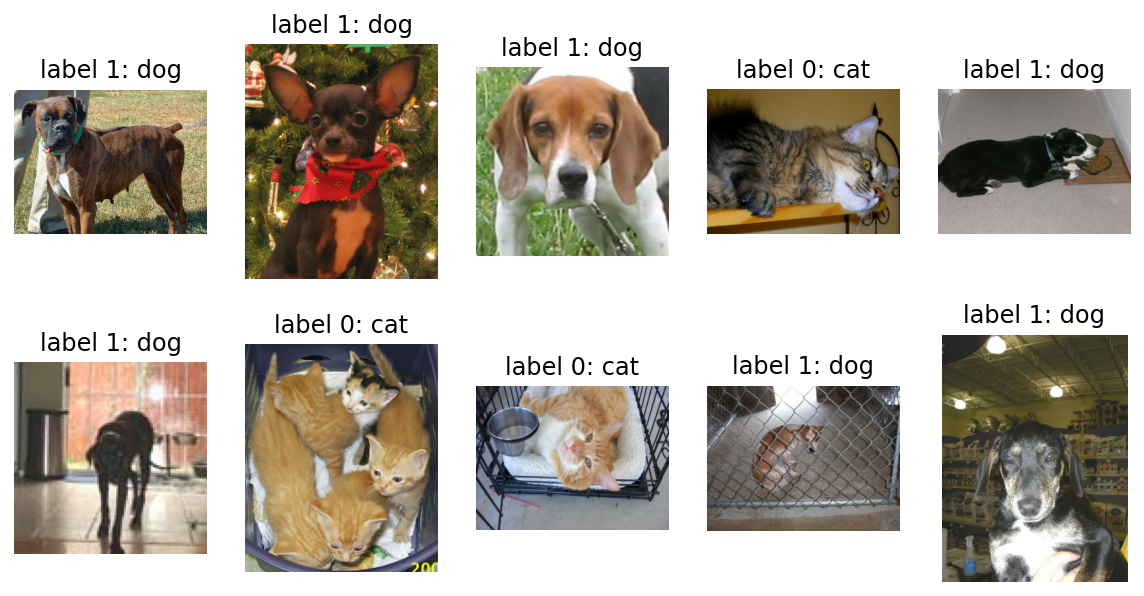

In [7]:
plt.figure(figsize=(10, 5))

get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(raw_train.take(10)):  # 10개의 데이터를 가져 옵니다.
    plt.subplot(2, 5, idx+1)
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

보다시피 이미지의 사이즈가 전부 다르다. 학습을 시키기 전에 이미지 사이즈를 통일시켜 주는 작업을 해보자.

`format_example()` 함수를 이용해 이미지를 같은 포맷으로 통일시켜 보자.
이미지를 160x160 픽셀로 통일하고, 각 픽셀의 scale을 수정해주자.

- ‍🌈추가정보 - 타입캐스팅(Type Casting)
  - 데이터를 다른 데이터 타입으로 변환해주는 것을 의미한다.
  - ex. float()


In [8]:
IMG_SIZE = 160 # 리사이징할 이미지의 크기

def format_example(image, label):
    image = tf.cast(image, tf.float32)  # image=float(image)같은 타입캐스팅의  텐서플로우 버전입니다.
    image = (image/127.5) - 1 # 픽셀값의 scale 수정 # 기존 0~255 정수값을 -1~1사이 실수값으로 변경
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

print("완료")

완료


그럼 이제 `format_example()` 함수를 raw_train, raw_validation, raw_test 에 `map() `함수로 적용시켜서 원하는 모양의 trian, val, test dataset으로 변환해보자.

In [9]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)
# 모든 이미지 크기를 (160,160,3)으로 통일

print(train)
print(validation)
print(test)

<MapDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>
<MapDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>
<MapDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>


위 코드와 아래 코드는 2가지가 다르다.
1. raw_data -> data
2. -1 ~ 1사이의 픽셀값을 1을 더한 후 2로 나눠서 0~1사이 값으로 반환함.   
(bc:maplotlib으로 이미지를 시각화 할 경우에는 모든 픽셀값이 양수여야 함)

In [ ]:
plt.figure(figsize=(10, 5))


get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(train.take(10)):
    plt.subplot(2, 5, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

 ## (4) 데이터가 준비되었으니, 텐서플로우를 활용해 모델 구조를 설계하자.
___
먼저 모델 생성에 필요한 함수들을 가져오자.
매우 자주 쓰이는 함수들이니, 이름을 잘 익혀두자.
   

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

print("완료")

완료


- models는 모델 자체를 구축하기 위한 함수를 포함하고,   
- layers는 모델의 구성 요소인 layer 관련 함수들을 가지고 있다.

- Sequntial은 말 그대로 "연속적인" 모델을 쌓기 위한 함수이다. 이 함수 안에 여러 레이어들이 연속적으로 들어간다.

In [12]:
model = Sequential([
    Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', input_shape=(160, 160, 3)),
    MaxPooling2D(),
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(units=512, activation='relu'),
    Dense(units=2, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 160, 160, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 80, 80, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 80, 80, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 40, 40, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 40, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 20, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 25600)             0

## (5) 모델 complie 후 학습시키기
___
`컴파일`이란 **모델을 학습시키기 위한 학습과정을 설정하는 단계**이다.
학습률 파라미터를 설정하고, 모델을 컴파일하자.

컴파일을 위해서는 `optimizer`, `loss`, `metrics` 이 세 가지가 필요하다.
1. optimizer: 학습 방식
2. loss: 모델이 학습해갈 방향. 이 문제에서는 crossentropy 확률분포로 두었다.    
`cross entroypy`: a measure of the difference between two probability distributions for a given random variable or set of events.
3. metrics: 모델의 성능을 평가하는 척도. 예를 들어, 정확도(acc), 정밀도(precision), 재현율(recall) 등이 있다.

In [13]:
learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

print("완료")

완료


모델을 컴파일했으니, 모델을 학습시킬 데이터를 준비하자.

한 스텝에 학습시킬 데이터의 개수인 `BATCH_SIZE`와 학습 데이터를 적절히 섞어줄 `SHUFFLE_BUFFER_SIZE`를 설정하자.

In [14]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000
print("완료")

완료


train_batches, validation_batches, test_batches를 만들어주자.    
train_batches는 모델이 계속 학습하도록 전체 데이터 중에서 32개를 랜덤으로 뽑아서 제공해준다.

In [15]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)
print("완료")

완료


하나의 batch만 꺼내서 데이터를 확인해보자.

In [16]:
for image_batch, label_batch in train_batches.take(1):
    pass


image_batch.shape, label_batch.shape 

(TensorShape([32, 160, 160, 3]), TensorShape([32]))

In [17]:
EPOCHS = 5
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/5
170/582 [=======>......................] - ETA: 16s - loss: 0.6612 - accuracy: 0.5998

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


202/582 [=========>....................] - ETA: 15s - loss: 0.6534 - accuracy: 0.6101

212/582 [=========>....................] - ETA: 15s - loss: 0.6509 - accuracy: 0.6120

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


284/582 [=============>................] - ETA: 12s - loss: 0.6379 - accuracy: 0.6281

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


492/582 [========================>.....] - ETA: 3s - loss: 0.6045 - accuracy: 0.6617

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


506/582 [=========================>....] - ETA: 3s - loss: 0.6023 - accuracy: 0.6637

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 2s - loss: 0.6008 - accuracy: 0.6652

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 1s - loss: 0.5964 - accuracy: 0.6687

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


550/582 [===========================>..] - ETA: 1s - loss: 0.5955 - accuracy: 0.6694

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.5919 - accuracy: 0.6724

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 59s 45ms/step - loss: 0.5919 - accuracy: 0.6724 - val_loss: 0.5340 - val_accuracy: 0.7420
Epoch 2/5
169/582 [=======>......................] - ETA: 16s - loss: 0.5093 - accuracy: 0.7480

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


203/582 [=========>....................] - ETA: 15s - loss: 0.5034 - accuracy: 0.7525

212/582 [=========>....................] - ETA: 14s - loss: 0.5034 - accuracy: 0.7537

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


284/582 [=============>................] - ETA: 11s - loss: 0.5031 - accuracy: 0.7559

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


492/582 [========================>.....] - ETA: 3s - loss: 0.4885 - accuracy: 0.7641

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


506/582 [=========================>....] - ETA: 3s - loss: 0.4870 - accuracy: 0.7650

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 2s - loss: 0.4865 - accuracy: 0.7655

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 1s - loss: 0.4834 - accuracy: 0.7678

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


550/582 [===========================>..] - ETA: 1s - loss: 0.4830 - accuracy: 0.7679

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


580/582 [============================>.] - ETA: 0s - loss: 0.4813 - accuracy: 0.7689

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 26s 43ms/step - loss: 0.4811 - accuracy: 0.7688 - val_loss: 0.6002 - val_accuracy: 0.7051
Epoch 3/5
169/582 [=======>......................] - ETA: 17s - loss: 0.4380 - accuracy: 0.8018

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


203/582 [=========>....................] - ETA: 15s - loss: 0.4415 - accuracy: 0.7982

213/582 [=========>....................] - ETA: 15s - loss: 0.4392 - accuracy: 0.8003

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 12s - loss: 0.4383 - accuracy: 0.7988

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


493/582 [========================>.....] - ETA: 3s - loss: 0.4209 - accuracy: 0.8074

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


505/582 [=========================>....] - ETA: 3s - loss: 0.4211 - accuracy: 0.8074

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 2s - loss: 0.4205 - accuracy: 0.8081

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


543/582 [==========================>...] - ETA: 1s - loss: 0.4187 - accuracy: 0.8089

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


549/582 [===========================>..] - ETA: 1s - loss: 0.4187 - accuracy: 0.8090

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/582 [============================>.] - ETA: 0s - loss: 0.4175 - accuracy: 0.8096

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 26s 43ms/step - loss: 0.4174 - accuracy: 0.8098 - val_loss: 0.5095 - val_accuracy: 0.7571
Epoch 4/5
169/582 [=======>......................] - ETA: 17s - loss: 0.3882 - accuracy: 0.8267

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


203/582 [=========>....................] - ETA: 15s - loss: 0.3883 - accuracy: 0.8267

213/582 [=========>....................] - ETA: 15s - loss: 0.3901 - accuracy: 0.8260

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 12s - loss: 0.3821 - accuracy: 0.8317

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


493/582 [========================>.....] - ETA: 3s - loss: 0.3676 - accuracy: 0.8376

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


505/582 [=========================>....] - ETA: 3s - loss: 0.3677 - accuracy: 0.8379

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 2s - loss: 0.3663 - accuracy: 0.8390

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


543/582 [==========================>...] - ETA: 1s - loss: 0.3641 - accuracy: 0.8410

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


549/582 [===========================>..] - ETA: 1s - loss: 0.3640 - accuracy: 0.8408

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/582 [============================>.] - ETA: 0s - loss: 0.3631 - accuracy: 0.8414

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 26s 43ms/step - loss: 0.3630 - accuracy: 0.8414 - val_loss: 0.4900 - val_accuracy: 0.7730
Epoch 5/5
169/582 [=======>......................] - ETA: 17s - loss: 0.3356 - accuracy: 0.8585

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


203/582 [=========>....................] - ETA: 15s - loss: 0.3344 - accuracy: 0.8615

213/582 [=========>....................] - ETA: 15s - loss: 0.3340 - accuracy: 0.8611

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


285/582 [=============>................] - ETA: 12s - loss: 0.3271 - accuracy: 0.8644

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


493/582 [========================>.....] - ETA: 3s - loss: 0.3147 - accuracy: 0.8701

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


505/582 [=========================>....] - ETA: 3s - loss: 0.3135 - accuracy: 0.8705

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 2s - loss: 0.3134 - accuracy: 0.8708

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


543/582 [==========================>...] - ETA: 1s - loss: 0.3117 - accuracy: 0.8717

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


549/582 [===========================>..] - ETA: 1s - loss: 0.3107 - accuracy: 0.8724

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/582 [============================>.] - ETA: 0s - loss: 0.3098 - accuracy: 0.8721

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 26s 43ms/step - loss: 0.3098 - accuracy: 0.8722 - val_loss: 0.4912 - val_accuracy: 0.7760


## (6) 모델 학습곡선 확인 및 예측 결과 시각화
___
학습 단계에 따른 정확도 변화를 확인해보자.

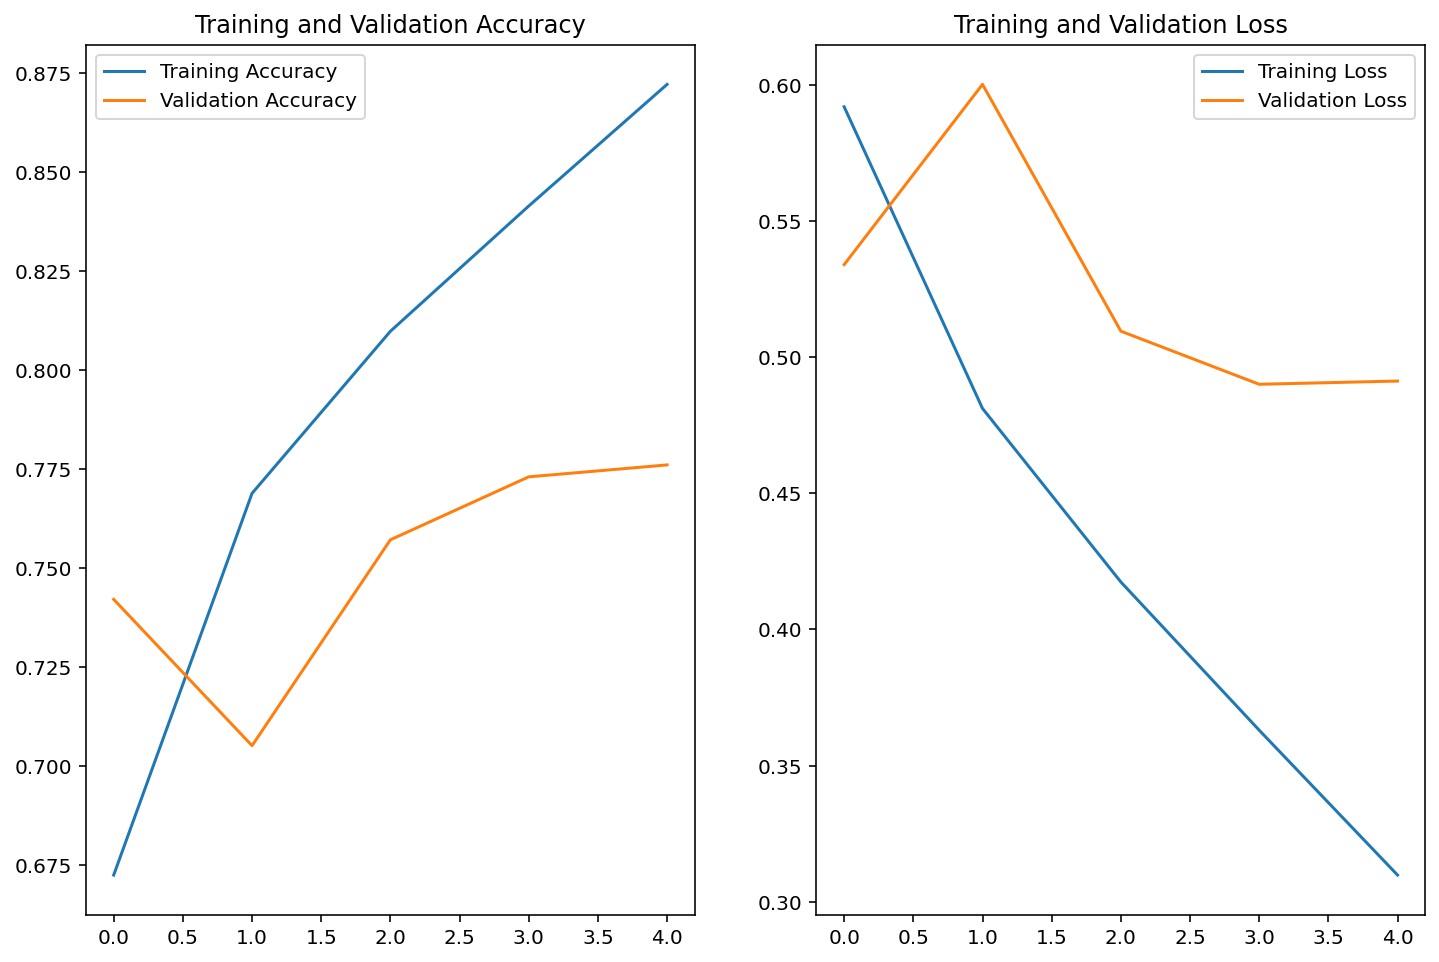

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

마지막으로 모델의 예측 결과를 확인해보자.(`model.predict`사용)

In [19]:
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = model.predict(image_batch)
    pass

predictions

array([[9.9463403e-01, 5.3659594e-03],
       [8.6157703e-01, 1.3842297e-01],
       [7.2451156e-01, 2.7548844e-01],
       [9.9763012e-01, 2.3699068e-03],
       [8.6519474e-01, 1.3480522e-01],
       [3.4874287e-01, 6.5125716e-01],
       [2.9946175e-01, 7.0053828e-01],
       [8.6350042e-01, 1.3649957e-01],
       [4.4359687e-01, 5.5640316e-01],
       [2.3671556e-01, 7.6328450e-01],
       [4.6083659e-01, 5.3916341e-01],
       [9.8782152e-01, 1.2178527e-02],
       [9.9192739e-01, 8.0726109e-03],
       [7.2749481e-03, 9.9272501e-01],
       [9.5456159e-01, 4.5438379e-02],
       [9.7633797e-01, 2.3662083e-02],
       [5.4798383e-01, 4.5201612e-01],
       [4.7695058e-04, 9.9952304e-01],
       [8.8669986e-01, 1.1330016e-01],
       [8.8460737e-01, 1.1539260e-01],
       [6.2138599e-01, 3.7861395e-01],
       [9.6755970e-01, 3.2440290e-02],
       [9.9551660e-01, 4.4834274e-03],
       [8.6918300e-01, 1.3081701e-01],
       [9.3028492e-01, 6.9715060e-02],
       [3.9772126e-01, 6.

이를 실제 추론한 라벨로 변환해보자.(고양이:0, 강아지:1)

In [20]:
import numpy as np
predictions = np.argmax(predictions, axis=1)
predictions

array([0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0])

이들을 시각화해서 확인하자.

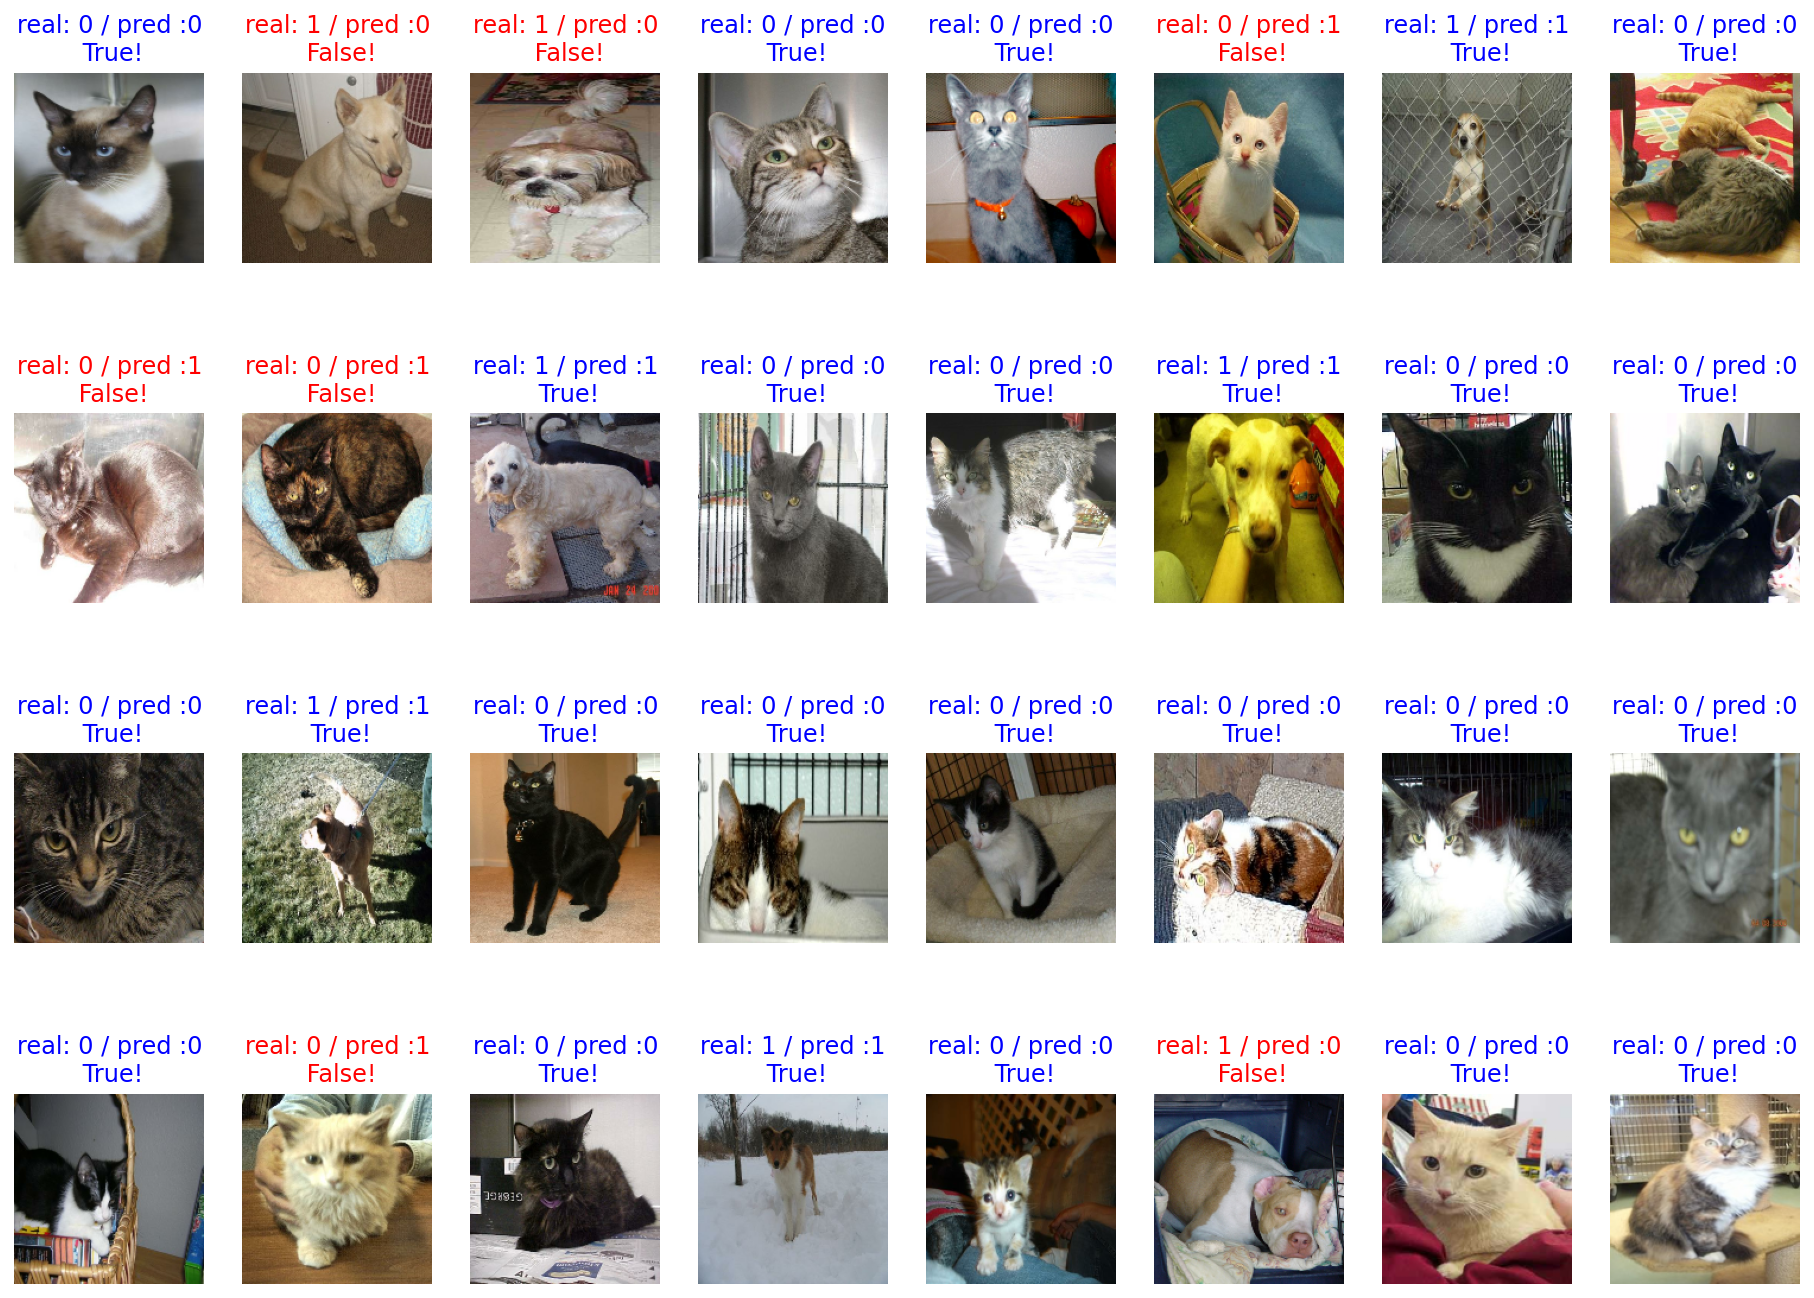

In [21]:
plt.figure(figsize=(16,12))

for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    
    plt.subplot(4, 8, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    correct = label == prediction
    title = f'real: {label} / pred :{prediction}\n {correct}!'
    if not correct:
        plt.title(title, fontdict={'color': 'red'})
    else:
        plt.title(title, fontdict={'color': 'blue'})
    plt.axis('off')

In [22]:
# 위 32개의 이미지에 대한 정확도를 뽑아내기

count = 0   # 정답을 맞춘 개수
for image, label, prediction in zip(images, labels, predictions):
    correct = label == prediction
    if correct:
        count += 1

print(count / 32 * 100)

78.125


# 내가 직접 만들지 않고 가져다 쓰는 강아지 고양이 분류기 
 ##  (1) 어려운 문제는 직접 풀지 말자, 똑똑한 누군가가 이미 풀어놨을 테니!
 ____
 
 ### 이미지 분류 대회인 ILSVRC와 데이터셋 ImageNet
- ILSVRC는 ImageNet Large Scale Visual Recognition Challenge의 약자로, 이미지를 분류하는 대회이다.
- 2017년 이후 대회에서 활약하는 모델들의 성능이 사실상 사람을 뛰어 넘었다고 판단되었기 때문에 종료되었다.
- 대회에서 사용되는 데이터셋은 ImageNet이라는 데이터셋으로, 총 1000개의 카테고리와 수백 만의 이미지 데이터로 이루어져 있다.

우리는 이 모델을 사용해 **Transfer Learning**을 할 예정이다.   

**Transfer Learning** :the use of previously acquired knowledge and skills in new learning or problem-solving situations

Transfer Learning에는 3가지 전략이 있는데, 다음과 같다.

1. 전체 모델을 새로 학습시키는 것   
모델을 완전히 새로 학습시켜야하므로, 큰 사이즈의 데이터셋과 좋은 컴퓨팅 연산 능력이 있을 때 적합하다.

2. Convolutional base의 일부분은 고정시킨 상태로, 나머지 계층과 classifier만 새로 학습시키는 것   
데이터셋의 크기에 따라 얼마나 많은 계층을 새로 학습시킬지 달라지는데, 데이터의 양이 많을수록 더 많이 새로 학습시키고, 데이터의 양이 적을수록 학습시키는 부분을 적게 한다.

3. Convolutional base는 고정시키고, classifier만 새로 학습시키는 것   
 이 경우는 convolutional base는 건들지 않고 그대로 두면서 특징 추출 메커니즘으로 활용하고, classifier만 재학습시키는 방법이다. 컴퓨팅 연산능력이 부족하거나 데이터셋이 작을 때 고려해볼 수 있다. (오늘 할 예정)

___


- 일반적인 CNN 모델은 크게 Convolutional base와 Classifier로 파트가 나뉜다.
   - Convolutional base : 이미지로부터 특징을 효과적으로 추출한다 (feature extraction)
     - input과 가까운 낮은 레벨의 계층에서는 이미지에 대한 general한 특징을 추출하고,
     - input과 먼 높은 레벨의 계층에서는 이미지에 대한 specific한 특징을 추출한다.
   - Classifier : 추출된 특징을 잘 학습해서 이미지를 알맞은 카테고리로 분류한다(image classification)



##  (2) 사전학습 모델은 VGG16을 가져오고, 모델의 구조 확인하기
___
VGG는 단순한 구조임에도 꽤나 괜찮은 성능을 보여서 아직까지 많은 이미지 처리 분야에서 사랑받는 모델 중 하나이다.

간단한 코드로 VGG model을 base_model의 변수로 불러오자.

`include_top = False`옵션을 주어야 output에 가까운 높은 레벨의 3개의 FC 레이어는 제거된다는 점 놓치치 말자!!

In [23]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model VGG16
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet')

58900480/58889256 [==============================] - 0s 0us/step


이 모델은 이미지를 입력받으면 이미지 특징을 뽑아낸 특징 벡터를 추출해준다.
한번 확인해보자.

In [35]:
image_batch.shape

TensorShape([32, 160, 160, 3])

32장의 이미지, 그리고 각 이미지의 크기는 160, 160, 3이며, 채널은 RGB임을 확인할 수 있다.

여기에 이 배치를 넣으면 사이즈가 어떻게 변하는지 살펴보자.

In [36]:
feature_batch = base_model(image_batch)
feature_batch.shape

TensorShape([32, 5, 5, 512])

이미지수는 같지만 사이즈가 변하고 채널이 늘어난 걸 알 수 있다.

이 벡터는 이미지에서 특징을 추출해 낸 "특징 벡터"라고 부르기도 한다.

그렇다면 모델 구조는 어떤지 볼까?

In [32]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 160, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 160, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 80, 80, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 80, 80, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 80, 80, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 40, 128)       0     

summary를 보면, 기존 모델에 있던 Dense layer가 빠짐을 확인할 수 있는데, 이는 우리가 include_top=false로 하여 classifier를 가져오지 않았기 때문이다.

## (3) 모델의 마지막 부분만, 내 입맛대로 재구성하기
**VGG16 끝단에 classifier 레이어를 붙여서 원하는 구조의 분류 모델 만들기**

VGG16 모델을 가져와서 모델이 이미지로부터 특징 벡터를 출력한다는 것을 확인했다.   
이제는 classifier를 직접 구상해야 한다.   

이를 구상하기 위해, 무엇이 들어가야 하는지 알아야 한다.
그러기 위해선, VGG16 모델이 출력한 벡터의 shape를 확인해야한다.


In [37]:
feature_batch.shape #  (32, 5, 5, 512)

TensorShape([32, 5, 5, 512])

이제 classifier를 구성하려면 Fully connected layer로 구성해야한다.

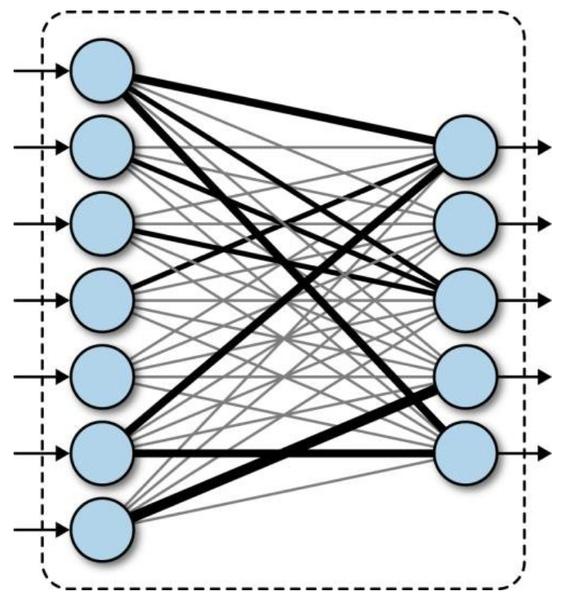

https://www.researchgate.net/figure/Types-of-pooling-d-Fully-Connected-Layer-At-the-end-of-a-convolutional-neural-network_fig3_337105858

이와 같이 생겼으며, 이전 계층의 모든 숫자들이 다음 계층의 모든 숫자와 연결돼야 한다. 그렇기에, 벡터의 모양은 반드시 **1차원이어야 한다**

그리고, 이전에는 Flatten layer를 통해서 3차원이었던 벡터를 1차원으로 shape을 바꿔주었다.

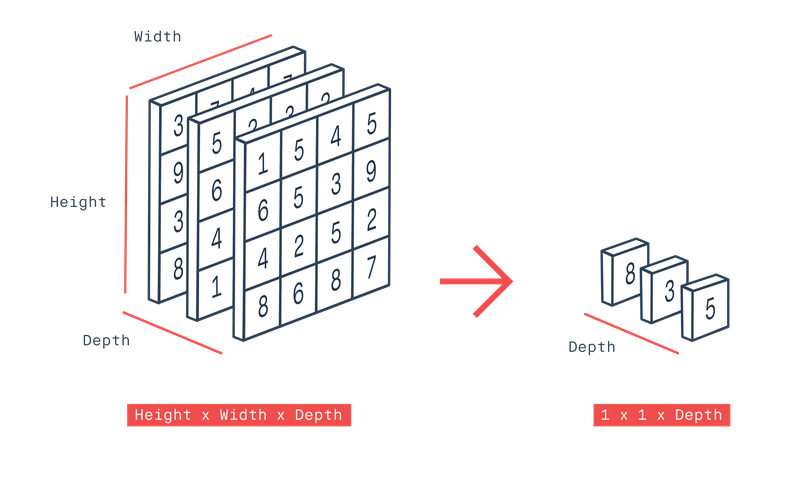
https://peltarion.com/knowledge-center/documentation/modeling-view/build-an-ai-model/blocks/global-average-pooling-2d


하지만, 이번에는 그보다 더 좋은 방법인 `Global Average Pooling` 연산을 통해 벡터의 shape을 바꿔보자. `Global Average Pooling`은 3차원의 벡터가 있을 때, 겹쳐서 쌓여있는 2차원 배열의 평균을 구한 후 하나의 값으로 축소하는 기법이다.


[Global Average Pooling 설명](https://peltarion.com/knowledge-center/documentation/modeling-view/build-an-ai-model/blocks/global-average-pooling-2d)

바로 `Global Average Pooling` 계층을 만드는 코드를 확인해보자.

In [38]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [39]:
# 이 layer에 VGG16이 출력했던 feature_batch를 입력해보자
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 512)


In [40]:
# 여기에 Dense layer만 붙여주면 classifier가 완성된다!

dense_layer = tf.keras.layers.Dense(512, activation='relu')
prediction_layer = tf.keras.layers.Dense(2, activation='softmax')

# feature_batch_averag가 dense_layer를 거친 결과가 다시 prediction_layer를 거치게 되면
prediction_batch = prediction_layer(dense_layer(feature_batch_average))  
print(prediction_batch.shape)

(32, 2)


이제 데이터들은 처음 이미지에서 VGG16, base_model을 통해 특징이 추출되고, 그 특징 벡터는 global_average_layer를 거쳐 마지막에 prediction_layer까지 통과하여 강아지인지, 고양이인지 예측이 될 것이다.

base_model은 학습시키지 않을 에정이니, `trainable`변수를 False로 지정해주자.

In [41]:
base_model.trainable = False
print("슝~")

슝~


### 최종모델

In [44]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer, # flatten
  dense_layer,
  prediction_layer
])


model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 5, 5, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 1026      
Total params: 14,978,370
Trainable params: 263,682
Non-trainable params: 14,714,688
_________________________________________________________________


## (4) VGG16을 기반으로 구성된 이미지 분류기를 학습시키고, 직접 만들었던 모델과 결과 비교해 보기

이제 모델 학습은 위에서 한 과정과 같다. optimizer, loss, metrics를 준비해서 모델을 컴파일하면 된다!

In [45]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

In [47]:
# 초기 손실과 정확도 검사

validation_steps=20
loss0, accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

 6/20 [========>.....................] - ETA: 0s - loss: 0.8284 - accuracy: 0.4583

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


18/20 [==========================>...] - ETA: 0s - loss: 0.8211 - accuracy: 0.4705

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


20/20 [==============================] - 5s 64ms/step - loss: 0.8203 - accuracy: 0.4703
initial loss: 0.82
initial accuracy: 0.47


In [48]:
# 학습 시켜보자.

EPOCHS = 5   # 이번에는 이전보다 훨씬 빠르게 수렴되므로 5Epoch이면 충분합니다.

history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/5
167/582 [=======>......................] - ETA: 33s - loss: 0.3982 - accuracy: 0.8546

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


200/582 [=========>....................] - ETA: 31s - loss: 0.3762 - accuracy: 0.8647

210/582 [=========>....................] - ETA: 30s - loss: 0.3689 - accuracy: 0.8679

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


282/582 [=============>................] - ETA: 24s - loss: 0.3317 - accuracy: 0.8815

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


490/582 [========================>.....] - ETA: 7s - loss: 0.2754 - accuracy: 0.8997

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


503/582 [========================>.....] - ETA: 6s - loss: 0.2727 - accuracy: 0.9002

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


514/582 [=========================>....] - ETA: 5s - loss: 0.2710 - accuracy: 0.9007

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 3s - loss: 0.2652 - accuracy: 0.9027

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


547/582 [===========================>..] - ETA: 2s - loss: 0.2640 - accuracy: 0.9032

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.2584 - accuracy: 0.9054

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 59s 99ms/step - loss: 0.2584 - accuracy: 0.9054 - val_loss: 0.1768 - val_accuracy: 0.9269
Epoch 2/5
167/582 [=======>......................] - ETA: 33s - loss: 0.1635 - accuracy: 0.9330

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


200/582 [=========>....................] - ETA: 31s - loss: 0.1614 - accuracy: 0.9344

210/582 [=========>....................] - ETA: 30s - loss: 0.1606 - accuracy: 0.9348

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


282/582 [=============>................] - ETA: 24s - loss: 0.1644 - accuracy: 0.9330

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


490/582 [========================>.....] - ETA: 7s - loss: 0.1619 - accuracy: 0.9349

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


503/582 [========================>.....] - ETA: 6s - loss: 0.1621 - accuracy: 0.9346

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


514/582 [=========================>....] - ETA: 5s - loss: 0.1614 - accuracy: 0.9346

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 3s - loss: 0.1611 - accuracy: 0.9347

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


547/582 [===========================>..] - ETA: 2s - loss: 0.1605 - accuracy: 0.9350

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1595 - accuracy: 0.9356

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 53s 89ms/step - loss: 0.1595 - accuracy: 0.9356 - val_loss: 0.1547 - val_accuracy: 0.9359
Epoch 3/5
167/582 [=======>......................] - ETA: 33s - loss: 0.1433 - accuracy: 0.9381

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


200/582 [=========>....................] - ETA: 31s - loss: 0.1453 - accuracy: 0.9386

210/582 [=========>....................] - ETA: 30s - loss: 0.1473 - accuracy: 0.9378

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


282/582 [=============>................] - ETA: 24s - loss: 0.1475 - accuracy: 0.9375

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


490/582 [========================>.....] - ETA: 7s - loss: 0.1481 - accuracy: 0.9371

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


503/582 [========================>.....] - ETA: 6s - loss: 0.1473 - accuracy: 0.9375

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


514/582 [=========================>....] - ETA: 5s - loss: 0.1467 - accuracy: 0.9377

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 3s - loss: 0.1464 - accuracy: 0.9381

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


547/582 [===========================>..] - ETA: 2s - loss: 0.1467 - accuracy: 0.9381

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1458 - accuracy: 0.9392

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 53s 89ms/step - loss: 0.1458 - accuracy: 0.9392 - val_loss: 0.1555 - val_accuracy: 0.9385
Epoch 4/5
167/582 [=======>......................] - ETA: 33s - loss: 0.1334 - accuracy: 0.9435

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


200/582 [=========>....................] - ETA: 31s - loss: 0.1377 - accuracy: 0.9427

210/582 [=========>....................] - ETA: 30s - loss: 0.1379 - accuracy: 0.9423

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


282/582 [=============>................] - ETA: 24s - loss: 0.1398 - accuracy: 0.9410

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


490/582 [========================>.....] - ETA: 7s - loss: 0.1395 - accuracy: 0.9424

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


503/582 [========================>.....] - ETA: 6s - loss: 0.1399 - accuracy: 0.9420

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


514/582 [=========================>....] - ETA: 5s - loss: 0.1394 - accuracy: 0.9421

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 3s - loss: 0.1389 - accuracy: 0.9424

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


547/582 [===========================>..] - ETA: 2s - loss: 0.1385 - accuracy: 0.9426

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1392 - accuracy: 0.9422

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 53s 89ms/step - loss: 0.1392 - accuracy: 0.9422 - val_loss: 0.1427 - val_accuracy: 0.9377
Epoch 5/5
167/582 [=======>......................] - ETA: 34s - loss: 0.1289 - accuracy: 0.9463

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


200/582 [=========>....................] - ETA: 31s - loss: 0.1289 - accuracy: 0.9469

210/582 [=========>....................] - ETA: 30s - loss: 0.1311 - accuracy: 0.9457

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


282/582 [=============>................] - ETA: 24s - loss: 0.1355 - accuracy: 0.9436

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


490/582 [========================>.....] - ETA: 7s - loss: 0.1359 - accuracy: 0.9438

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


503/582 [========================>.....] - ETA: 6s - loss: 0.1363 - accuracy: 0.9433

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


514/582 [=========================>....] - ETA: 5s - loss: 0.1356 - accuracy: 0.9436

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 3s - loss: 0.1354 - accuracy: 0.9439

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


547/582 [===========================>..] - ETA: 2s - loss: 0.1352 - accuracy: 0.9438

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1339 - accuracy: 0.9445

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


582/582 [==============================] - 53s 89ms/step - loss: 0.1339 - accuracy: 0.9445 - val_loss: 0.1416 - val_accuracy: 0.9385


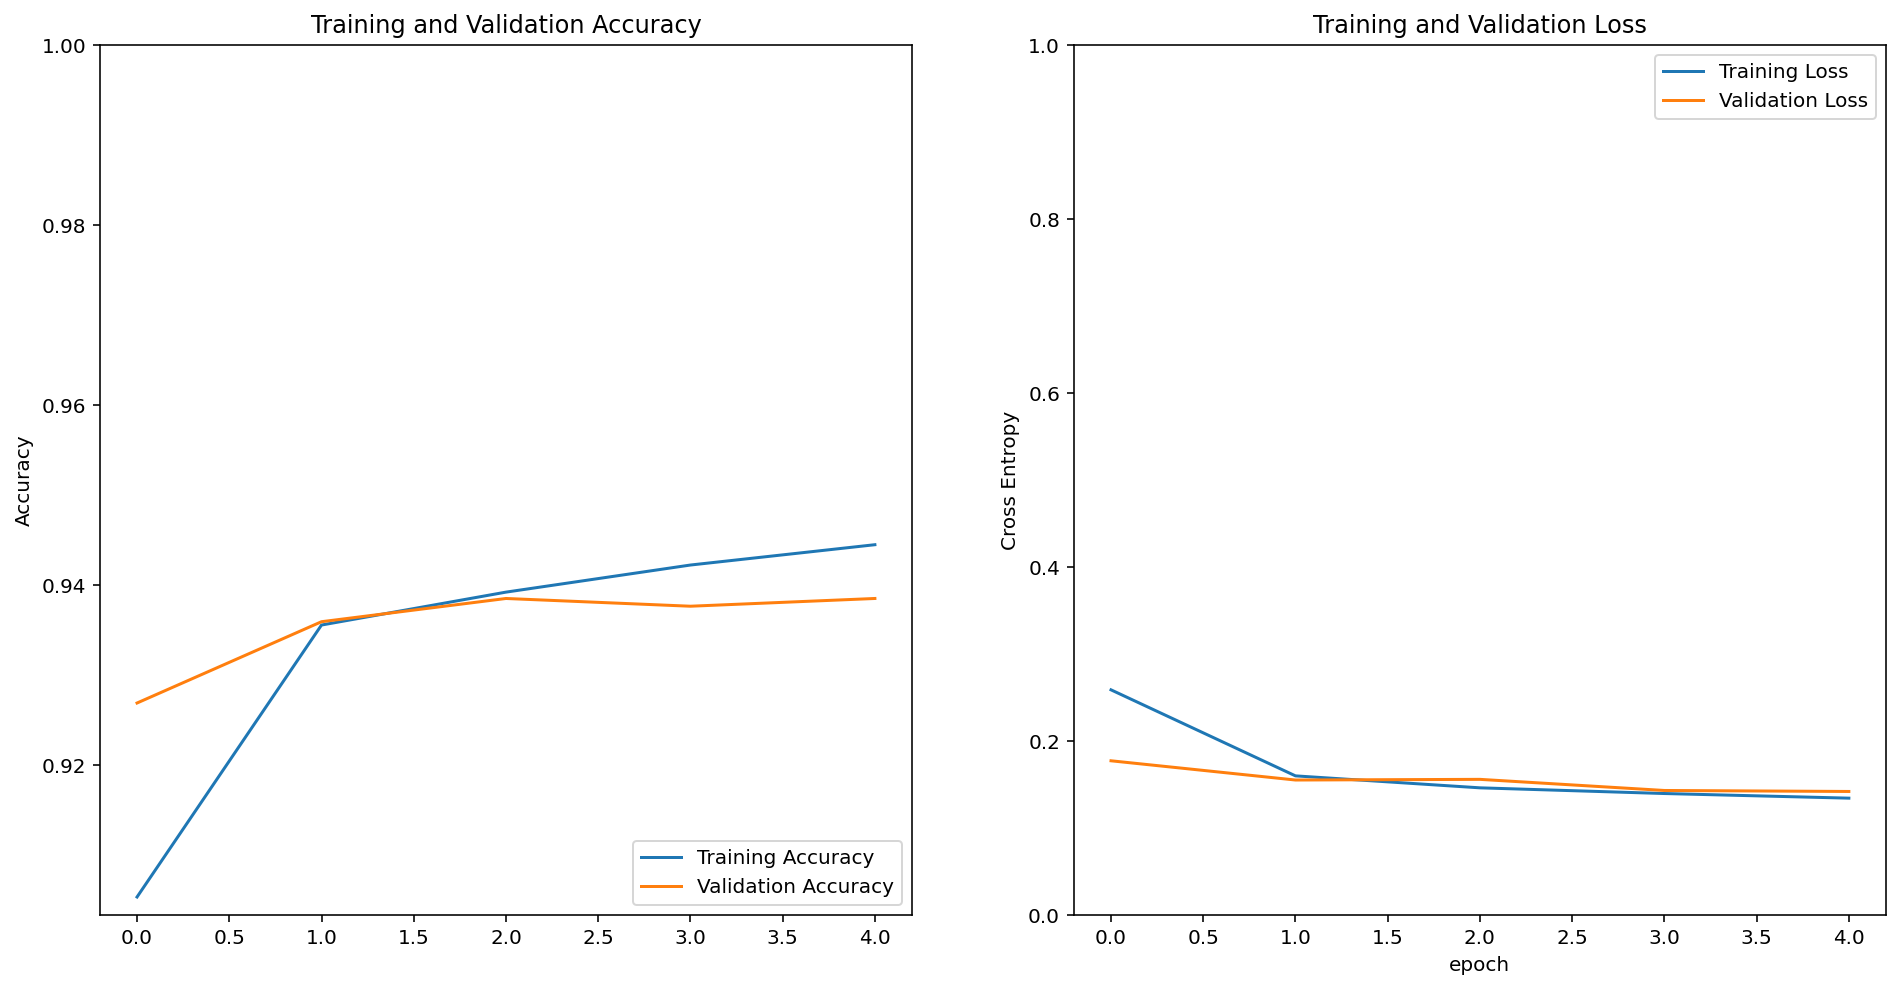

In [50]:
# 그래프로 학습과정을 보자

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

위에서 한 것처럼 32개의 test sample에 대한 예측 결과를 눈으로 확인해보자. 샘플은 test_batches에서 가져온다.

In [52]:
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = model.predict(image_batch)
    pass

predictions

array([[9.9999082e-01, 9.1388374e-06],
       [1.4407119e-01, 8.5592878e-01],
       [4.8832053e-01, 5.1167953e-01],
       [9.9999714e-01, 2.8432544e-06],
       [9.9848431e-01, 1.5157171e-03],
       [9.9029458e-01, 9.7054560e-03],
       [2.8860811e-04, 9.9971133e-01],
       [7.6263636e-01, 2.3736364e-01],
       [9.7493047e-01, 2.5069501e-02],
       [9.8112005e-01, 1.8879963e-02],
       [1.1022244e-04, 9.9988973e-01],
       [9.9995542e-01, 4.4600740e-05],
       [9.9318522e-01, 6.8147569e-03],
       [6.9993175e-06, 9.9999297e-01],
       [9.9893922e-01, 1.0608067e-03],
       [9.9058342e-01, 9.4166147e-03],
       [9.9731100e-01, 2.6890391e-03],
       [4.2605676e-02, 9.5739436e-01],
       [7.0070899e-01, 2.9929096e-01],
       [9.9633551e-01, 3.6644747e-03],
       [9.3502283e-01, 6.4977191e-02],
       [9.8799729e-01, 1.2002685e-02],
       [9.9578094e-01, 4.2191148e-03],
       [9.8363876e-01, 1.6361220e-02],
       [9.9885023e-01, 1.1497369e-03],
       [9.8798800e-01, 1.

In [53]:
# prediction값을 라벨로 변환
import numpy as np
predictions = np.argmax(predictions, axis=1)
predictions

array([0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0])

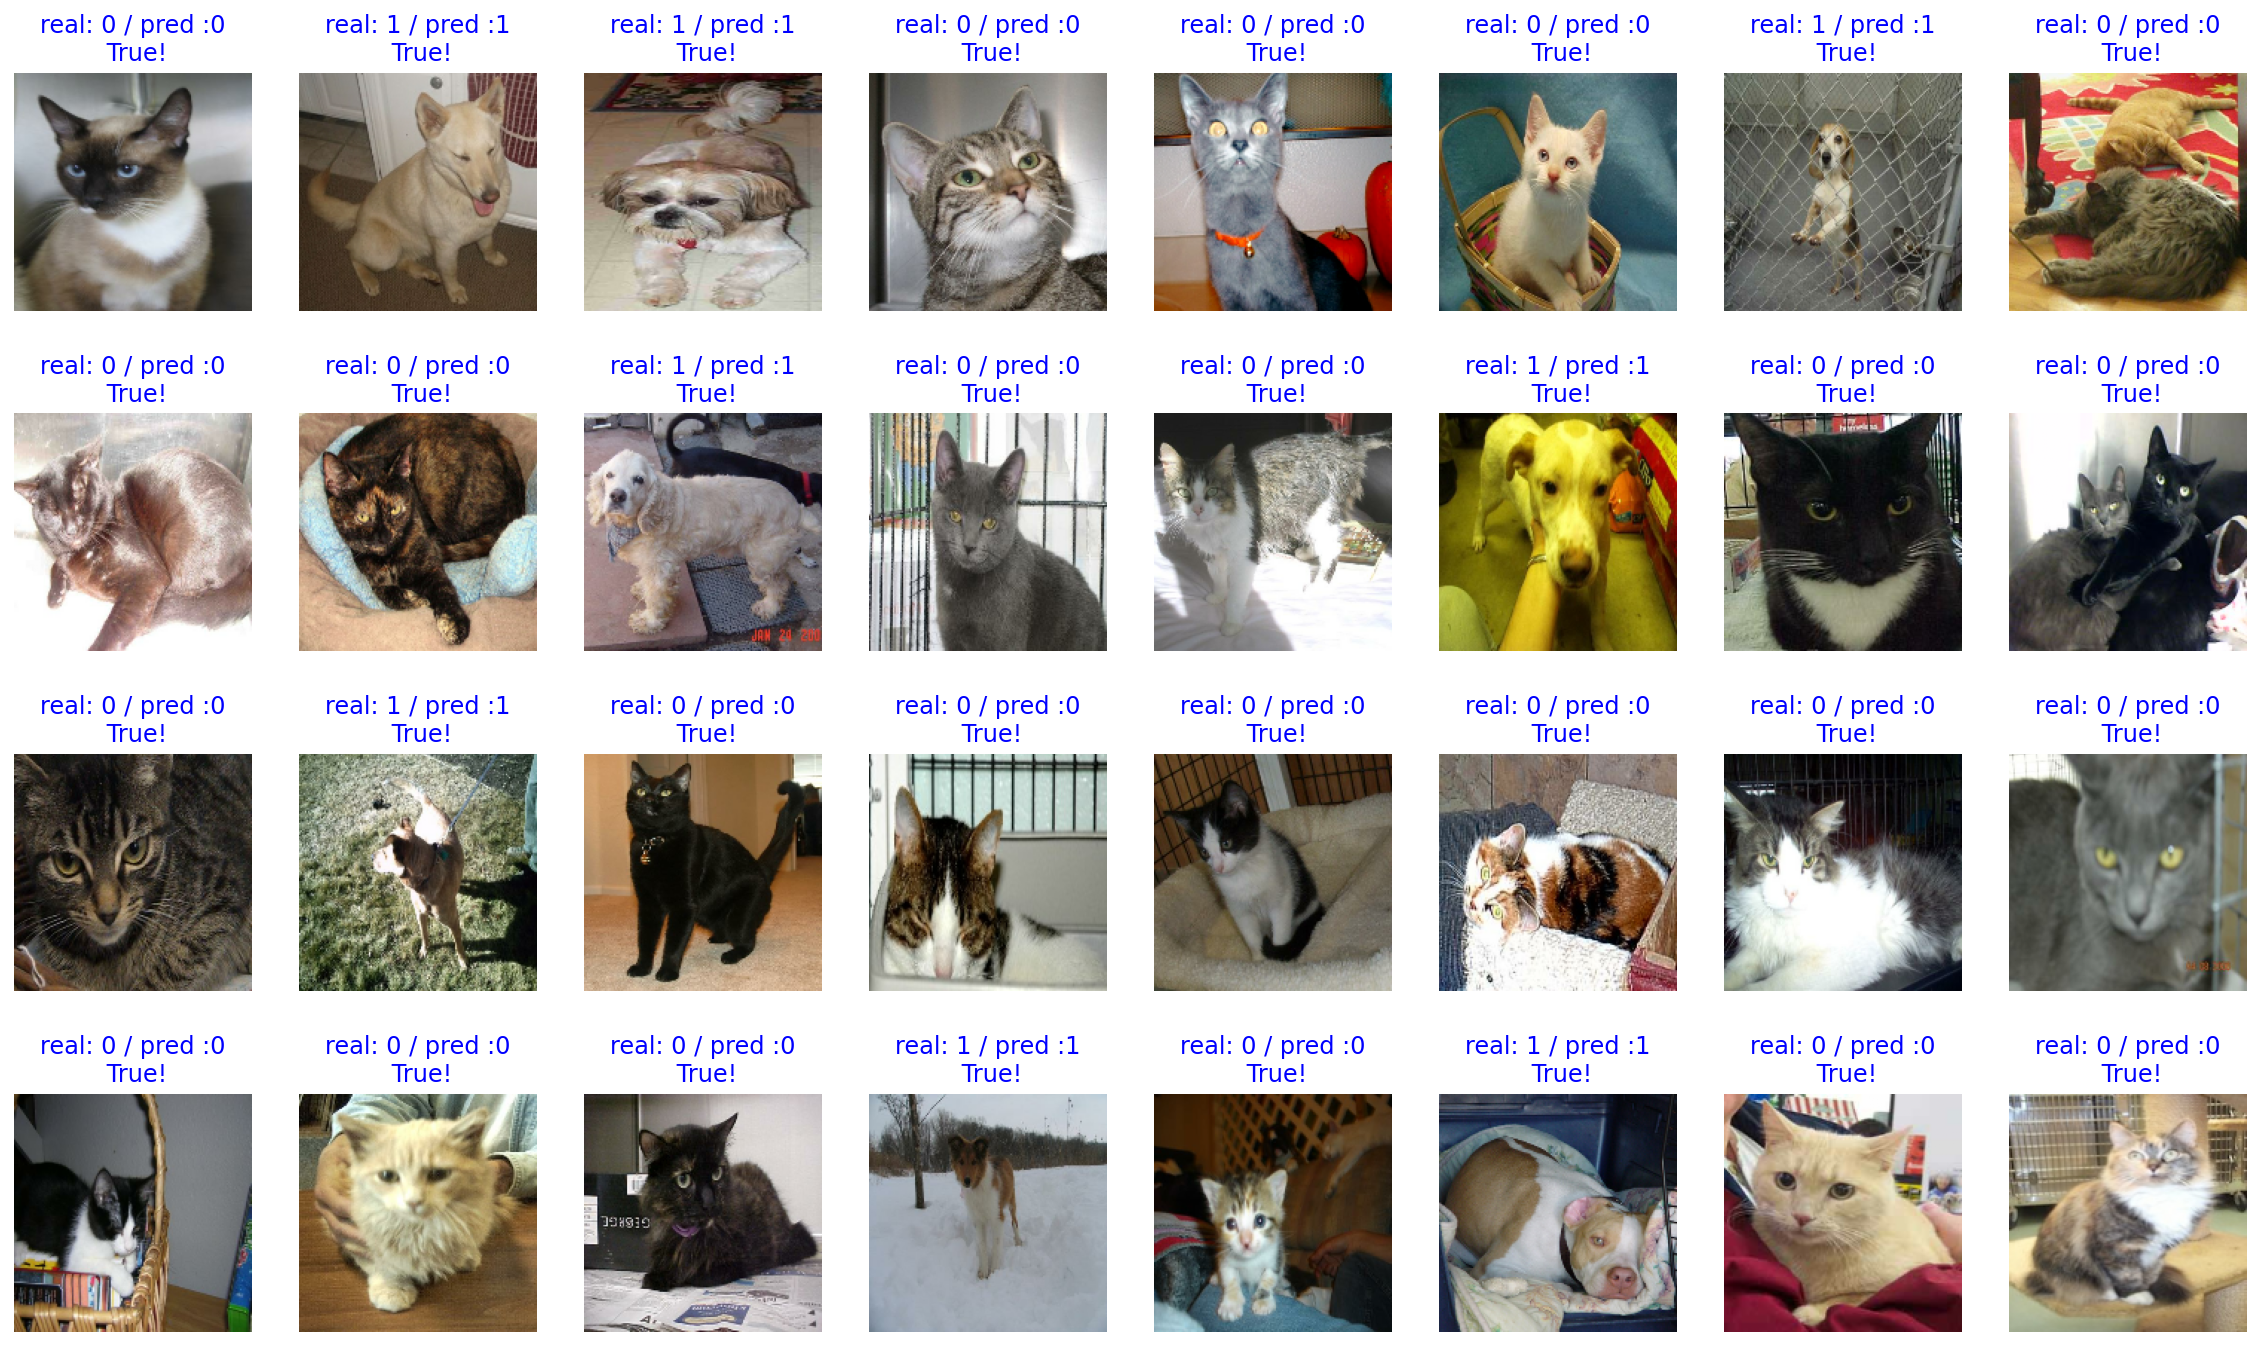

In [54]:
#확인
plt.figure(figsize=(20, 12))

for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    plt.subplot(4, 8, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    correct = label == prediction
    title = f'real: {label} / pred :{prediction}\n {correct}!'
    if not correct:
        plt.title(title, fontdict={'color': 'red'})
    else:
        plt.title(title, fontdict={'color': 'blue'})
    plt.axis('off')

In [55]:
#정확도 측정
count = 0
for image, label, prediction in zip(images, labels, predictions):
    correct = label == prediction
    if correct:
        count = count + 1

print(count / 32 * 100) # 약 95% 내외

100.0


## (5) 잘 학습된 모델은 저장해두고, 언제든 꺼내 쓰도록 하자!
**모델을 save 하고, 다시 load 해와서 사용하는 방법 익히기**

모델은 저장하는 법은 생각보다 간단하다.
파라미터로 저장하고 싶은 경로만 입력하고, `save_weights`함수를 활용하면 된다!

```
$ mkdir -p ~/aiffel/cat_vs_dog
$ mkdir -p ~/aiffel/cat_vs_dog/checkpoint
$ mkdir -p ~/aiffel/cat_vs_dog/images
```

In [56]:
import os

checkpoint_dir = os.getenv("HOME") + "/aiffel/cat_vs_dog/checkpoint"
checkpoint_file_path = os.path.join(checkpoint_dir, 'checkpoint')

if not os.path.exists('checkpoint_dir'):
    os.mkdir('checkpoint_dir')
    
model.save_weights(checkpoint_file_path)     # checkpoint 파일 생성

if os.path.exists(checkpoint_file_path):
  print('checkpoint 파일 생성 OK!!')

checkpoint 파일 생성 OK!!


## (6) 거울아 거울아, 나는 멍멍이 상이니, 아니면 냥이 상이니?
**학습된 모델에 원하는 이미지를 입력해 예측 결과 확인해 보기**

이제 원하는 이미지를 넣어 모델의 예측 결과를 확인해보자.
원하는 이미지를 원하는 경로에 지정해주자.

In [57]:
img_dir_path = os.getenv("HOME") + "/aiffel/cat_vs_dog/images"
os.path.exists(img_dir_path)

True

In [59]:
# 이미지가 저장되었다면, 이제 tensorflow 모델에 입력해주기 위해 load_img, img_to_array 함수를 가져오자.
from tensorflow.keras.preprocessing.image import load_img, img_to_array

이미지 모델은 160,160 사이즈만 입력받을 수 있기 때문에 파라미터로 이미지 사이즈를 넣어야 한다.

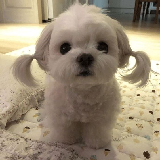

In [60]:
IMG_SIZE = 160
dog_image_path = os.path.join(img_dir_path, 'my_dog.jpeg')

dog_image = load_img(dog_image_path, target_size=(IMG_SIZE, IMG_SIZE))
dog_image

load_img를 했으니, 이제 이미지를 array 즉 배열 자료형으로 변환해주자.

In [62]:
dog_image = img_to_array(dog_image).reshape(1, IMG_SIZE, IMG_SIZE, 3)
dog_image.shape

(1, 160, 160, 3)

위 과정을 함수로 만들어 원하는 이미지를 자유자재로 예측해보자!!

In [64]:
# image를 load & arrary로 변환(reshape) & predict & percentage

def show_and_predict_image(dirpath, filename, img_size=160):
    filepath = os.path.join(dirpath, filename)
    image = load_img(filepath, target_size=(img_size, img_size))
    plt.imshow(image)
    plt.axis('off')
    image = img_to_array(image).reshape(1, img_size, img_size, 3)
    prediction = model.predict(image)[0]
    cat_percentage = round(prediction[0] * 100)
    dog_percentage = round(prediction[1] * 100)
    print(f"This image seems {dog_percentage}% dog, and {cat_percentage}% cat.")


위와 같이 함수를 짜두면 filename만 바꾸어 원하는 대로 실험할 수 있다.

This image seems 100% dog, and 0% cat.


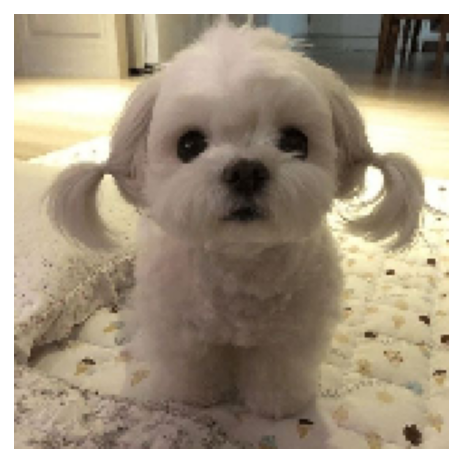

In [65]:
filename = 'my_dog.jpeg'

show_and_predict_image(img_dir_path, filename)